## INDEX

<ol>
<li>Imports</li>
<li>Functions</li>
<li>Exploratory data analysis</li>
<li>Data Preprocessing
    <ol>
    <li>Tokenization, Stopword Removal, Stemming</li>
    </ol>
</li>
<li>Modelling</li>
    <ol>
    <li>Bag of words (BOW)</li>
    <li>tfidf vectorizer</li>
    <li>Multinomial Naive Bayes BOW</li>
    <li>Multinomial Naive Bayes TF-IDF vectorizer</li>
    <li>Simple RNN</li>
    <li>LSTM</li>
    </ol>
<li>
</ol>


## 1.- IMPORTS

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import nltk
from nltk.tokenize import ToktokTokenizer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from keras.layers import LSTM

## 2.- FUNCTIONS

In [2]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    """
    Generate distribution graphs (histogram/bar graph) for each column in the DataFrame.

    Args:
    - df (DataFrame): The input DataFrame containing the data.
    - nGraphShown (int): The maximum number of graphs to be shown.
    - nGraphPerRow (int): The number of graphs to be displayed per row.

    Returns:
    - None: The function displays the graphs but does not return any value.
    """
    nunique = df.nunique()
    # For displaying purposes, pick columns that have between 1 and 50 unique values
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [3]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    """
    Generate a correlation matrix plot for the DataFrame.

    Args:
    - df (DataFrame): The input DataFrame containing the data.
    - graphWidth (int): The width of the correlation matrix plot.

    Returns:
    - None: The function displays the correlation matrix plot but does not return any value.
    """
    filename = df.dataframeName
    df = df.dropna()  # Drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # Keep columns where there are more than 1 unique values
    df = df.select_dtypes(include=['int', 'float'])
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [4]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    """
    Generate scatter and density plots for numerical columns in the DataFrame.

    Args:
    - df (DataFrame): The input DataFrame containing the data.
    - plotSize (int): The size of the scatter matrix plot.
    - textSize (int): The size of the text annotations.

    Returns:
    - None: The function displays the scatter and density plots but does not return any value.
    """
    df = df.select_dtypes(include=[np.number])  # Keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]]  # Keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10:  # Reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=(plotSize, plotSize), diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [5]:
def strip_html(text):
    """
    Remove HTML tags from the input text.

    Args:
    - text (str): The input text containing HTML tags.

    Returns:
    - str: The text with HTML tags removed.
    """
    if isinstance(text, str):  # Check if the text is a string
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    else:
        return text


In [6]:
def remove_between_square_brackets(text):
    """
    Remove text between square brackets (including the brackets) from the input text.

    Args:
    - text (str): The input text.

    Returns:
    - str: The text with content between square brackets removed.
    """
    if isinstance(text, str):  # Check if the text is a string
        return re.sub(r'\[[^]]*\]', '', text)
    else:
        return text


In [7]:
# Define the complete text cleaning function
def denoise_text(text):
    """
    Perform text denoising by removing HTML tags and text between square brackets.

    Args:
    - text (str): The input text.

    Returns:
    - str: The denoised text without HTML tags and content between square brackets.
    """
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text


In [8]:
def remove_special_characters(text, remove_digits=True):
    """
    Remove special characters from the input text.

    Args:
    - text (str): The input text.
    - remove_digits (bool): Whether to remove digits or not. Default is True.

    Returns:
    - str: The text with special characters removed.
    """
    if isinstance(text, str):
        pattern = r'[^a-zA-z0-9\s]'
        text = re.sub(pattern, '', text)
        if remove_digits:
            text = re.sub(r'\d+', '', text)  # Remove digits if specified
        return text
    else:
        return text


In [9]:
def simple_stemmer(text):
    """
    Perform simple stemming on the input text using the NLTK Porter Stemmer.

    Args:
    - text (str): The input text.

    Returns:
    - str: The text with words stemmed using the Porter Stemmer.
    """
    if isinstance(text, str):
        ps = nltk.porter.PorterStemmer()
        text = ' '.join([ps.stem(word) for word in text.split()])
        return text
    else:
        return text

In [10]:
def remove_stopwords(text, is_lower_case=False):
    """
    Remove stopwords from the input text.

    Args:
    - text (str): The input text.
    - is_lower_case (bool): Whether the text is lowercased or not. Default is False.

    Returns:
    - str: The text with stopwords removed.
    """
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


In [11]:
def plot_confusion_matrix(cm, labels):
    """
    Plot the confusion matrix.

    Args:
    - cm (array): The confusion matrix.
    - labels (list): The list of class labels.

    Returns:
    - None: The function displays the confusion matrix plot but does not return any value.
    """
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

## 3.- EXPLORATORY DATA ANALYSIS

In [12]:
nRowsRead = None # specify 'None' if want to read whole file
df1 = pd.read_csv('Womens_Clothing_E-Commerce_Reviews.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'Womens Clothing E-Commerce Reviews.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 23486 rows and 11 columns


In [13]:
df1.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


The first thing we do is to plot the distribution of the different variables in the dataset. The most important thing we can observe here is the class imbalance, which we will have to deal with later on.

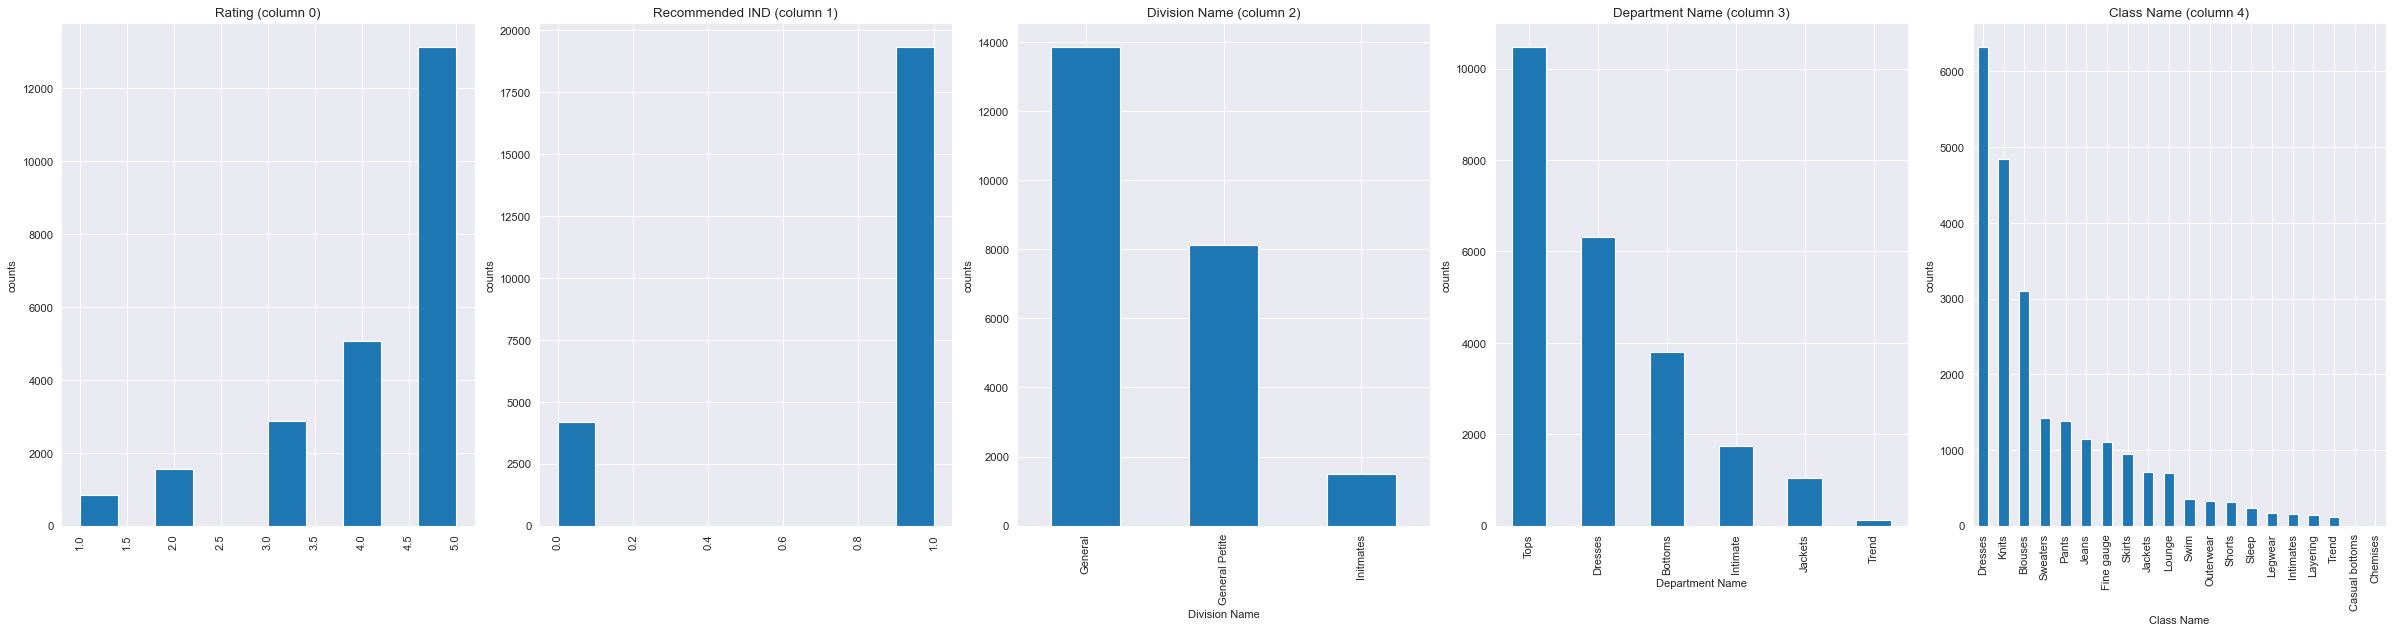

In [14]:
plotPerColumnDistribution(df1, 10, 5)

We can also plot the correlation matrix between the variables. The result is interesting, as we see a clear correlation between the rating and whether a product is recommended or not. Since we are going to predict the variable Recommended IND, we could get an idea of the rating just from this variable. This makes sense, as the product's rating should have an influence on whether we recommend it or not.

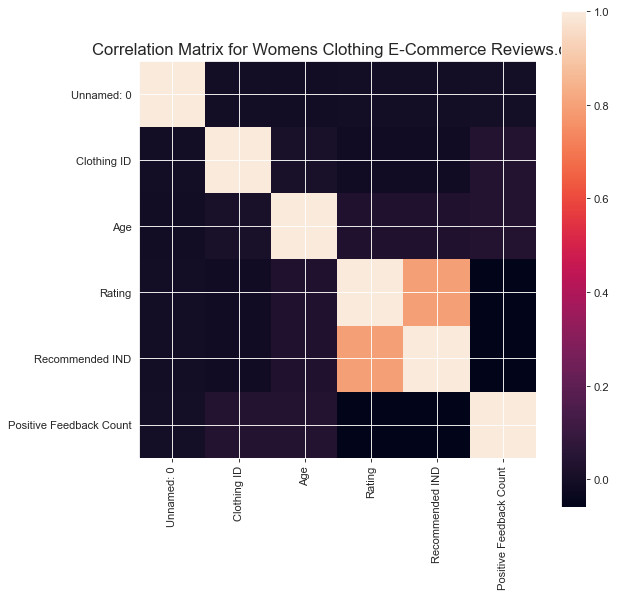

In [15]:
plotCorrelationMatrix(df1, 8)

Finally, we can try to create a scatterplot of the original dataframe. This is more aesthetically pleasing than informative, really. We can see the distribution of each variable separately and also the relationship between each pair of variables, but we cannot draw any significant conclusions that we didn't know before.

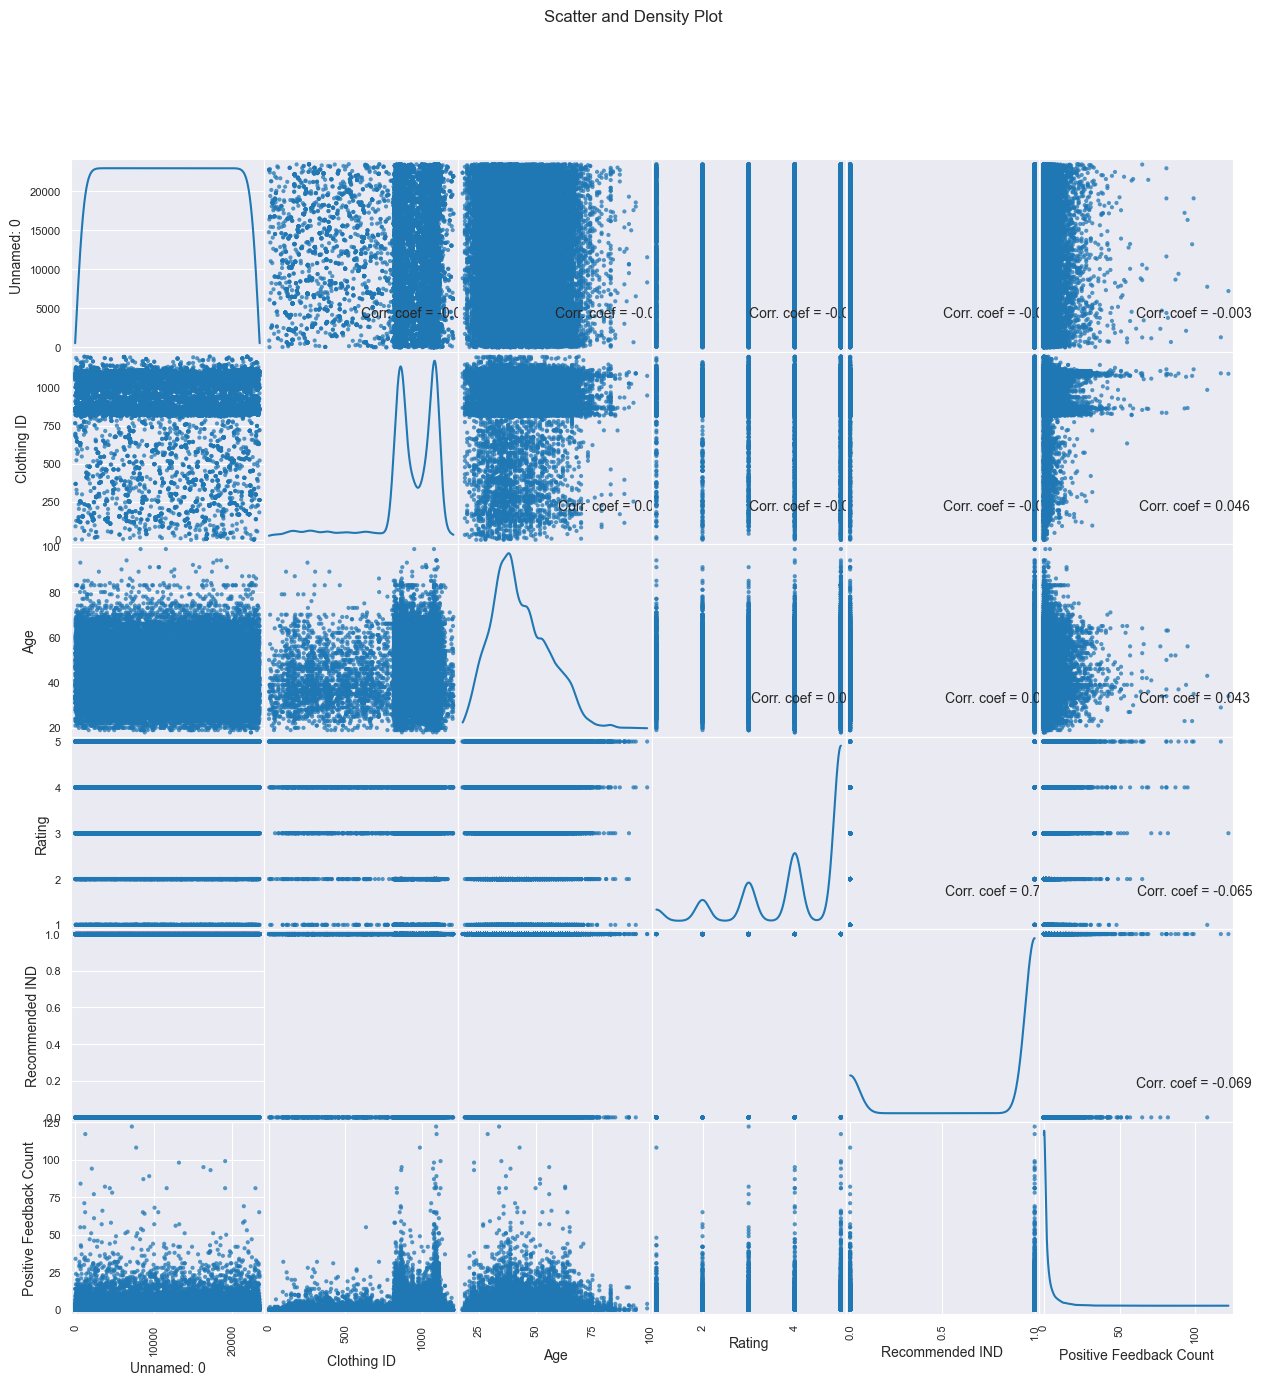

In [16]:
plotScatterMatrix(df1, 15, 10)

## 4.- DATA PREPROCESSING

Basically, what we're going to do here is transform our dataframe into a dataframe we can work with. The first problem we see, as we already knew, is the class imbalance.

In [17]:
df1['Rating'].value_counts()

Rating
5    13131
4     5077
3     2871
2     1565
1      842
Name: count, dtype: int64

In [18]:
df1['Recommended IND'].value_counts()

Recommended IND
1    19314
0     4172
Name: count, dtype: int64

We'll keep only the two columns that interest us and transform the target variable to an object type.

In [19]:
df1 = df1[['Review Text' , 'Recommended IND']]

In [20]:
df1['Recommended IND'].astype('object')

0        1
1        1
2        0
3        1
4        1
        ..
23481    1
23482    1
23483    0
23484    1
23485    1
Name: Recommended IND, Length: 23486, dtype: object

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Text      22641 non-null  object
 1   Recommended IND  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


First, we concatenate two subsets of our dataframe df1 using pd.concat(). These subsets are chosen in a way that balances the classes. The first part of pd.concat() selects all rows where the value of the column "Recommended IND" is 0 (indicating the product is not recommended), while the second part randomly selects a sample of 4200 rows where the value of "Recommended IND" is 1 (indicating the product is recommended). This is done to approximately equalize the number of samples between the two classes and avoid imbalance.

After concatenating these subsets, the resulting dataframe balanced_df is randomly shuffled to avoid any bias in the order of rows or in the selection of samples. This is done using .sample() with the same number of rows as the balanced_df dataframe.

In [22]:
balanced_df = pd.concat([df1[df1['Recommended IND'] == 0], df1[df1['Recommended IND'] == 1].sample(n=4200)], axis=0)

In [23]:
balanced_df = balanced_df.sample(len(balanced_df))

Now we can see the result, and indeed, we have solved the class imbalance problem.







In [24]:
balanced_df

,Review Text,Recommended IND
6853,"Saw this online and didn't catch my attention,...",1
15132,I really love this brand and i love the fit of...,1
19205,This dress was as pretty in real life as the p...,1
5422,I'm surprised this worked for so many people. ...,1
3043,I tried on and bought this shirt in my usual s...,0
...,...,...
12731,I had my eye on this dress since it fist came ...,1
12309,"Very cute dress, but fabric is very flimsy and...",0
14376,"Sadly, i returned this one. i'm a 36d bra size...",0
1806,This shirt was so weird?it does not fit like t...,0


In [25]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8372 entries, 6853 to 16244
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Text      8140 non-null   object
 1   Recommended IND  8372 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 196.2+ KB


<Axes: xlabel='count', ylabel='Recommended IND'>

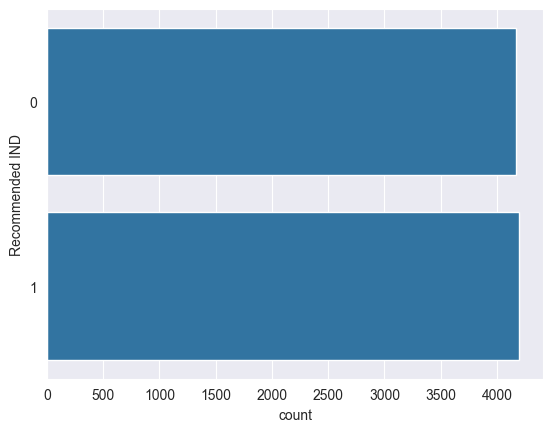

In [26]:
sns.countplot(y = balanced_df['Recommended IND'])

In [27]:
balanced_df['Recommended IND'] = balanced_df['Recommended IND'].astype('category')

In [28]:
balanced_df.describe()

,Review Text,Recommended IND
count,8140,8372
unique,8139,2
top,I purchased this and another eva franco dress ...,1
freq,2,4200


In [29]:
balanced_df['Recommended IND'].value_counts()

Recommended IND
1    4200
0    4172
Name: count, dtype: int64

We'll just change the names of the remaining two variables for convenience.

In [30]:
balanced_df.rename(columns={'Recommended IND': 'Recommended_Category'}, inplace=True)
balanced_df.rename(columns={'Review Text': 'Review'}, inplace=True)

### 4.1.- Tokenization, Stopword Removal, Stemming

First we apply a function called denoise_text to each element in the 'Review' column of the DataFrame balanced_df. The denoise_text function will remove noise from the text data, such as HTML tags, extra whitespaces, or special characters.

Then we apply another function named remove_special_characters to each element in the 'Review' column. This function will remove special characters like punctuation marks. This might not be necessary for some analysis, but it is recommended anyway.

Finally we apply a function called simple_stemmer to each element in the 'Review' column. Stemming is a text normalization technique that reduces words to their root or base form.

For more information just check the functions defined above.

In [31]:
# Aplicar la función de limpieza al dataframe
balanced_df['Review'] = balanced_df['Review'].apply(denoise_text)

C:\Users\jorge\AppData\Local\Temp\ipykernel_3384\826804364.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [32]:
#Aply function for removing special characters
balanced_df['Review'] = balanced_df['Review'].apply(remove_special_characters)

In [33]:
#Apply function for Stemming the text
balanced_df['Review'] = balanced_df['Review'].apply(simple_stemmer)

Tokenization is the process of breaking down text into smaller units, called tokens. These tokens are typically individual words, but they can also be parts of words or characters, depending on the desired level of granularity. Tokenization is fundamental in natural language processing because it converts text into a form that the computer can understand and process. In this case, by tokenizing the text, we are preparing it for easier analysis and manipulation in later steps of natural language processing.

 The following code prepares text data for analysis by downloading stopwords, tokenizing the text, setting English stopwords, and removing them from the text.

In [34]:
nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#Apply function for removing the stopwords
balanced_df['Review'] = balanced_df['Review'].apply(remove_stopwords)

{'only', 'shan', 'm', 'them', "doesn't", 'o', 'if', 'we', 'off', 'herself', "won't", 'hadn', 'they', 'whom', "shan't", 'more', 'but', 'yourself', 'my', 'don', 'no', 're', 'there', 'below', 'wouldn', 'has', 'weren', 'by', "it's", 'can', 'most', 'between', 'here', "hasn't", 'too', 'or', 'just', 'her', 'had', 've', "wouldn't", 'of', "aren't", 'while', 'what', 'some', 'ain', 'was', 'isn', 'am', 'being', 'themselves', 's', 'you', 'again', 'above', "you're", "weren't", 'will', 'his', 'for', "that'll", 'same', 'a', 'itself', "needn't", 'mightn', 'doing', 'down', 'is', 'then', 'over', 'having', 'each', 'won', 'needn', 'as', 'with', 'have', "mustn't", 'not', 'haven', 'after', "hadn't", 'our', 'me', 'these', 'into', 'aren', 'at', 'd', 'himself', "she's", 't', 'out', 'further', 'on', 'did', 'should', 'do', 'their', "couldn't", 'why', 'mustn', 'how', 'nor', 'were', 'ma', 'yourselves', 'he', 'its', 'it', 'myself', 'an', 'up', 'few', 'yours', "you've", 'such', "should've", 'didn', 'those', "mightn't

In [36]:
num = int(len(balanced_df)*0.8)
norm_train_reviews=balanced_df.Review[:num]
norm_test_reviews=balanced_df.Review[num:]

In [37]:
len(norm_train_reviews)

6697

In [38]:
len(norm_test_reviews)

1675

## 5.-MODELLING

### 5.1.- Bag of Words (BOW)

In a sentiment analysis model, the Bag of Words (BoW) model is used to represent text so that its emotional polarity can be analyzed. Instead of considering grammatical structure or word order in a sentence, BoW simply counts the frequency of words present in the text. This means each document is represented as a set of words, regardless of their sequence.
 
Although simple and effective, the BoW model doesn't capture the semantic meaning of words or the relationship between them, which may limit its ability to understand more subtle emotional context in the text. However, it usually use as a starting point for many sentiment analysis applications. And that is what we are doing here.







In [39]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (6697, 273619)
BOW_cv_test: (1675, 273619)


In [40]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(balanced_df['Recommended_Category'])
print(sentiment_data.shape)

(8372, 1)


In [41]:
train_sentiments=sentiment_data[:num]
test_sentiments=sentiment_data[num:]

In [42]:
lr=LogisticRegression(penalty='l2',max_iter=1000,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)

C:\Users\jorge\Documents\MasterBD\Datos_no_estructurados\PracticasAna\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=1000, random_state=42)


In [43]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

[1 0 0 ... 0 0 0]


In [44]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.8495522388059702


In [45]:
#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['1','0'])
print(lr_bow_report)

              precision    recall  f1-score   support

           1       0.85      0.84      0.85       825
           0       0.85      0.86      0.85       850

    accuracy                           0.85      1675
   macro avg       0.85      0.85      0.85      1675
weighted avg       0.85      0.85      0.85      1675


Confusion Matrix for Bag of Words:
[[732 118]
 [134 691]]


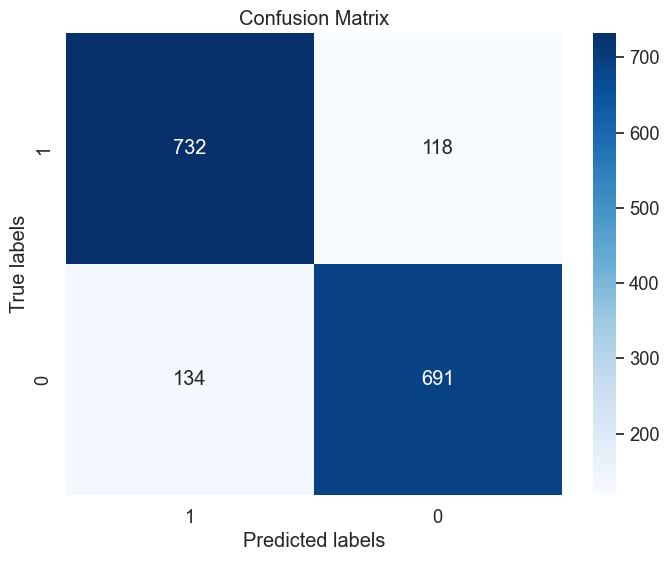

In [46]:
# Matriz de confusión para Bag of Words
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict, labels=[1, 0])
print("Confusion Matrix for Bag of Words:")
print(cm_bow)
plot_confusion_matrix(cm_bow, labels=['1', '0'])

### 5.2.- Tfidf vectorizer

In a sentiment analysis model, the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is employed to represent text, allowing for the analysis of its emotional polarity. Unlike the Bag of Words (BoW) model, which merely counts the frequency of words present in the text without considering their semantic meaning or relationship, TF-IDF assigns a weight to each word based on its frequency in the document and the corpus as a whole. This results in each document being represented as a set of words weighted according to their relative importance in the document and corpus.

While TF-IDF is more sophisticated than BoW as it considers the relative importance of words, it still has its limitations. For instance, it may not fully capture the semantic meaning of words or their relationships. Nevertheless, it often serves as a foundational step for many sentiment analysis applications, including the one we're conducting here.

In [47]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (6697, 273619)
Tfidf_test: (1675, 273619)


In [48]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=1000,C=1,random_state=42)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

C:\Users\jorge\Documents\MasterBD\Datos_no_estructurados\PracticasAna\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=1000, random_state=42)


In [49]:
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 0 0 ... 0 0 0]


In [50]:
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_tfidf_score : 0.8507462686567164


In [51]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['1','0'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

           1       0.84      0.86      0.85       825
           0       0.86      0.84      0.85       850

    accuracy                           0.85      1675
   macro avg       0.85      0.85      0.85      1675
weighted avg       0.85      0.85      0.85      1675


Confusion Matrix for TF-IDF:
[[714 136]
 [114 711]]


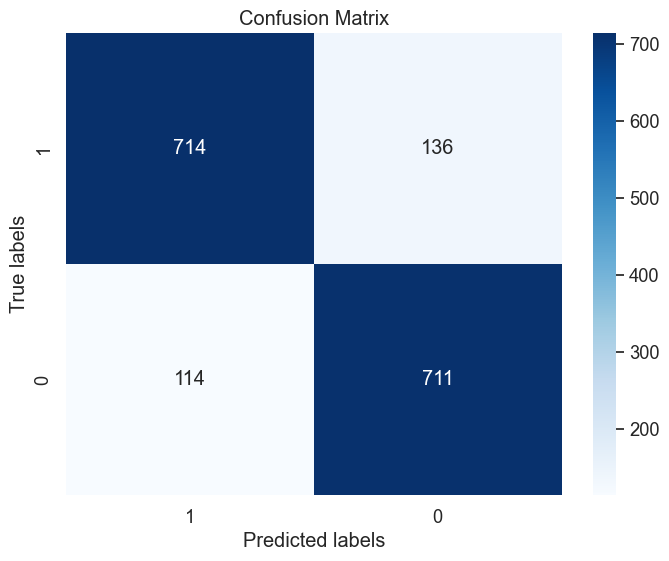

In [52]:
# Matriz de confusión para TF-IDF
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels=[1, 0])
print("Confusion Matrix for TF-IDF:")
print(cm_tfidf)
plot_confusion_matrix(cm_tfidf, labels=['1', '0'])

We observe that both models yield very similar results, with an accuracy of 0.85 for each. Each has its advantages and disadvantages. We see how the Bag of Words (BOW) model predicts more recommended items accurately, while the TF-IDF model performs better in predicting non-recommended items. In order to improve, we are going to try the multinomial naive bayes.

### 5.3 Multinomial Naive Bayes BOW

The Multinomial Naive Bayes classifier is a commonly used supervised learning algorithm in text classification tasks. It's often employed alongside these previous techniques: the Bag of Words (BoW) model and the TF-IDF vectorizer.

In the context of the Bag of Words model, Multinomial Naive Bayes assumes independence between the features (words) given the class (the category label to predict). Despite this independence assumption rarely holding true in practice, the classifier remains effective and easy to implement. It calculates the probability of a document belonging to each class given its set of features (words) using Bayes' theorem.

In [53]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)

MultinomialNB()


C:\Users\jorge\Documents\MasterBD\Datos_no_estructurados\PracticasAna\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

[1 0 0 ... 0 0 0]


In [55]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

mnb_bow_score : 0.8531343283582089


In [56]:
#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['1','0'])
print(mnb_bow_report)

              precision    recall  f1-score   support

           1       0.84      0.87      0.85       825
           0       0.87      0.84      0.85       850

    accuracy                           0.85      1675
   macro avg       0.85      0.85      0.85      1675
weighted avg       0.85      0.85      0.85      1675


Confusion Matrix for Bag of Words (Multinomial Naive Bayes):
[[710 140]
 [106 719]]


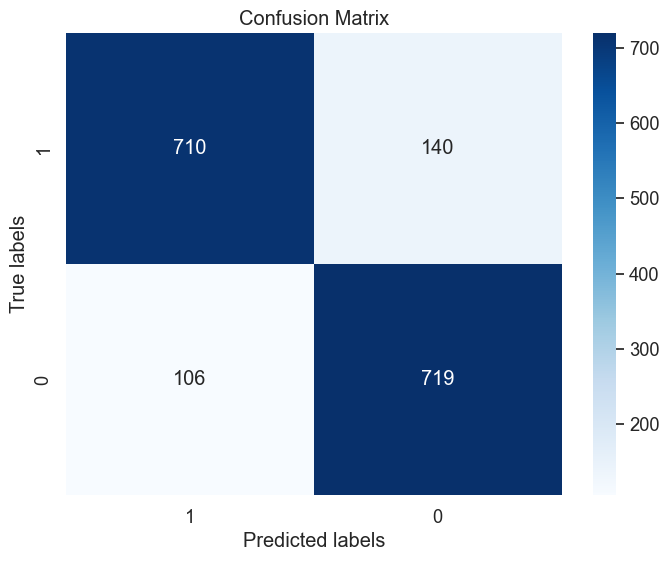

In [57]:
# Matriz de confusión para Bag of Words con Naive Bayes Multinomial
cm_bow_mnb = confusion_matrix(test_sentiments, mnb_bow_predict, labels=[1, 0])
print("Confusion Matrix for Bag of Words (Multinomial Naive Bayes):")
print(cm_bow_mnb)
plot_confusion_matrix(cm_bow_mnb, labels=['1', '0'])


### 5.4.- Multinomial Naive Bayes TF-IDF

When applied with the TF-IDF vectorizer, Multinomial Naive Bayes follows a similar logic. However, instead of working with raw word frequencies, it operates on the TF-IDF weighted values of words. This involves calculating the probability of a document belonging to each class given its TF-IDF representation (weighted term values) as we explained before.

In [58]:
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()


C:\Users\jorge\Documents\MasterBD\Datos_no_estructurados\PracticasAna\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [59]:
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 0 0 ... 0 0 0]


In [60]:
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_tfidf_score : 0.8549253731343284


In [61]:
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['1','0'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

           1       0.83      0.88      0.86       825
           0       0.88      0.83      0.85       850

    accuracy                           0.85      1675
   macro avg       0.86      0.86      0.85      1675
weighted avg       0.86      0.85      0.85      1675


Confusion Matrix for TF-IDF (Multinomial Naive Bayes):
[[706 144]
 [ 99 726]]


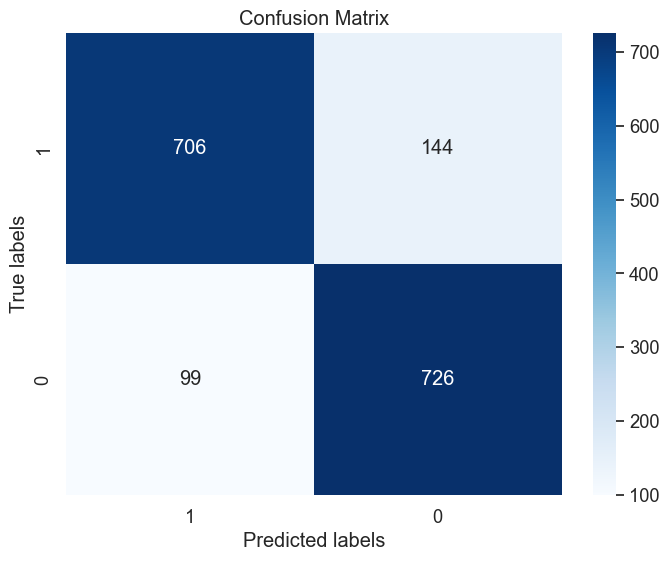

In [62]:
# Matriz de confusión para TF-IDF con Naive Bayes Multinomial
cm_tfidf_mnb = confusion_matrix(test_sentiments, mnb_tfidf_predict, labels=[1, 0])
print("Confusion Matrix for TF-IDF (Multinomial Naive Bayes):")
print(cm_tfidf_mnb)
plot_confusion_matrix(cm_tfidf_mnb, labels=['1', '0'])

We can see how we've improved the TF-IDF model but worsened the BOW model, although all models are very similar to each other. It seems that the Naive Bayes TF-IDF model has the highest accuracy. Let's try now a different approach.

Finally, we're going to train a couple of neural networks.

Bag of Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF) are traditional text representation techniques in sentiment analysis. They provide straightforward but limited representations compared to neural networks, which automatically learn complex patterns and relationships in data, including text, through training. Neural networks offer higher potential performance but require more computational resources and data for training and may lack interpretability compared to BoW and TF-IDF.

Here, since we don't have a large amount of data, neural networks shouldn't make a significant difference in their performance compared to the previous algorithms.

### 5.5.- Simple RNN

A Recurrent Neural Network (RNN) is a type of neural network tailored for sequential data processing. It possesses loops within its architecture, allowing it to maintain memory and capture information from preceding inputs. RNNs excel in tasks where the order of inputs carries significance. However, they often encounter difficulties in retaining long-term dependencies due to the vanishing gradient problem, hindering their effectiveness in sequences with extended context.

In [63]:
texts = balanced_df['Review'].values
labels = balanced_df['Recommended_Category'].values

# Tokenize the texts
max_words = 8000  # Consider only the top 10,000 words
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
maxlen = 500  # Cut texts after this number of words
data = pad_sequences(sequences, maxlen=maxlen)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (8372, 500)
Shape of label tensor: (8372,)


In [64]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print('Shape of training data tensor:', X_train.shape)
print('Shape of testing data tensor:', X_test.shape)
print('Shape of training label tensor:', y_train.shape)
print('Shape of testing label tensor:', y_test.shape)


Shape of training data tensor: (6697, 500)
Shape of testing data tensor: (1675, 500)
Shape of training label tensor: (6697,)
Shape of testing label tensor: (1675,)


In [65]:
model = Sequential()
model.add(Embedding(8000, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Entrenar el modelo
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_test, y_test))

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - acc: 0.5497 - loss: 0.6822 - val_acc: 0.6591 - val_loss: 0.6299
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - acc: 0.7645 - loss: 0.5383 - val_acc: 0.8101 - val_loss: 0.4464
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - acc: 0.8495 - loss: 0.3775 - val_acc: 0.8030 - val_loss: 0.4497
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - acc: 0.8592 - loss: 0.3404 - val_acc: 0.8072 - val_loss: 0.4334
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - acc: 0.8962 - loss: 0.2805 - val_acc: 0.7940 - val_loss: 0.4948
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - acc: 0.9276 - loss: 0.2341 - val_acc: 0.7940 - val_loss: 0.4932
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - acc: 0.9533 - loss: 0.1740 - val_acc: 0.7564 - val_loss: 0.5581
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - acc: 0.9482 - loss: 0.1823 - val_acc: 0.7678 - val_loss: 0.5271
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - acc: 0.9695

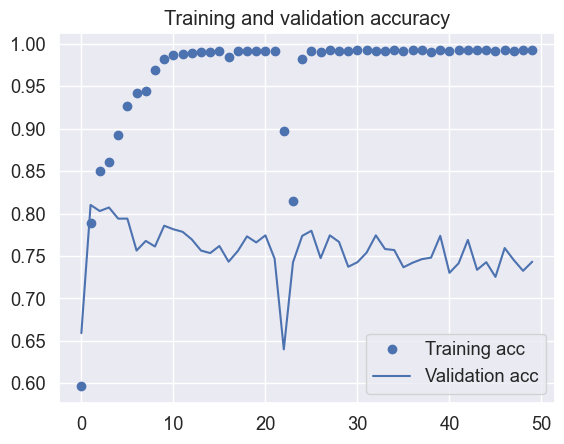

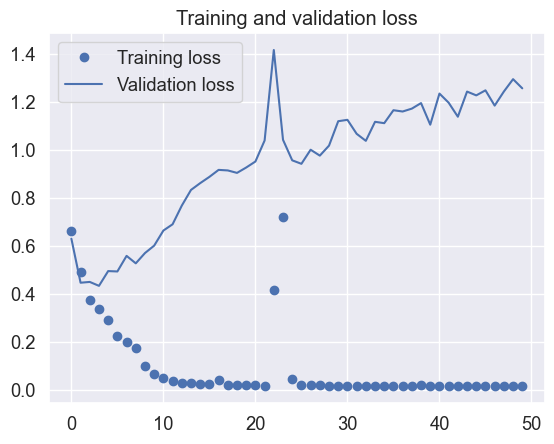

In [66]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 5.6.- LSTM

A Long Short-Term Memory (LSTM) network, a specialized type of RNN architecture, overcomes the limitations of traditional RNNs by introducing mechanisms to manage information flow over extended sequences. It includes memory cells and gating mechanisms, such as input, forget, and output gates, which facilitate the selective retention and forgetting of information. LSTMs excel in capturing and retaining long-term dependencies in sequential data, making them indispensable for tasks requiring a deep understanding of context and temporal relationships, such as natural language processing and time series prediction.

In [67]:
model = Sequential()
model.add(Embedding(8000, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Entrenar el modelo
history2 = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_test, y_test))

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - acc: 0.5907 - loss: 0.6813 - val_acc: 0.7009 - val_loss: 0.5914
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - acc: 0.7645 - loss: 0.5275 - val_acc: 0.7910 - val_loss: 0.5004
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - acc: 0.8355 - loss: 0.4188 - val_acc: 0.8245 - val_loss: 0.4055
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - acc: 0.8673 - loss: 0.3341 - val_acc: 0.8340 - val_loss: 0.3902
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - acc: 0.8901 - loss: 0.2934 - val_acc: 0.7815 - val_loss: 0.5023
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - acc: 0.8935 - loss: 0.2879 - val_acc: 0.7875 - val_loss: 0.5259
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - acc: 0.9014 - loss: 0.2629 - val_acc: 0.8322 - val_loss: 0.3974
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - acc: 0.9192 - loss: 0.2377 - val_acc: 0.8400 - val_loss: 0.4048
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step -

In [68]:
model.save("modelo_sentimientos.h5")

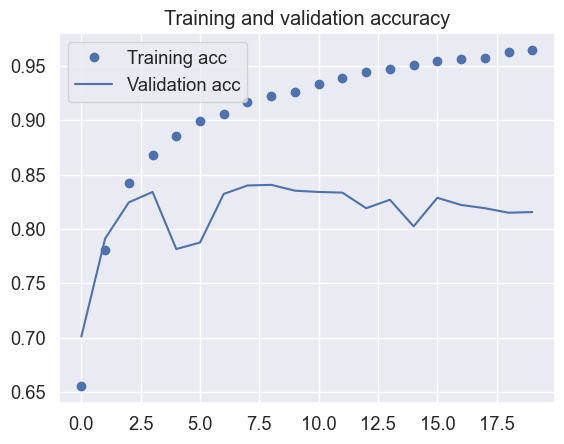

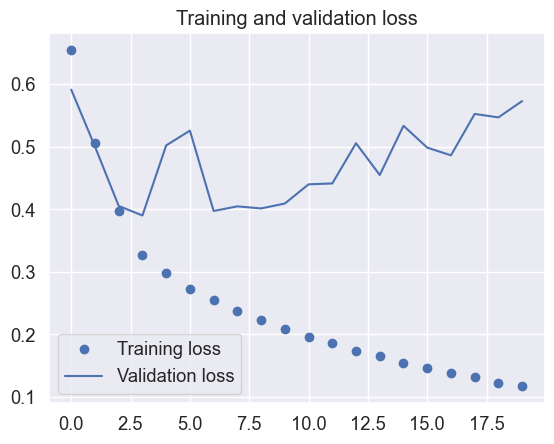

In [69]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As expected, both neural networks exhibit significant overfitting, with the RNN showing a more pronounced effect, achieving a training accuracy of 0.98 but only reaching around 0.80 on validation. With the LSTM, the overfitting is less exaggerated; in fact, the validation accuracy stabilizes around 0.85, which is comparable to what we had in the previous models. This could be further improved by using a larger dataset. Since the problem is quite simple and we do not have more data, it's probably best to use one of the simpler models we've used before to avoid overfitting.